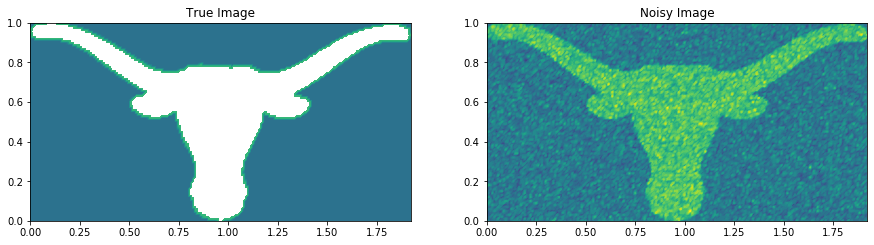

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

from dolfin import *
import math
import numpy as np
import logging
from unconstrainedMinimization import InexactNewtonCG

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
set_log_active(False)


# Set the level of noise:
noise_std_dev = .3

# Load the image from file
data = np.loadtxt('image.dat', delimiter=',')
np.random.seed(seed=1)

noise = noise_std_dev*np.random.randn(data.shape[0], data.shape[1])
Lx = float(data.shape[1])/float(data.shape[0])
Ly = 1.

mesh = RectangleMesh(Point(0,0),Point(Lx,Ly), 200, 100)
V = FunctionSpace(mesh, "Lagrange",1)

# Generate the true image (u_true) and the noisy data (u_0)
class Image(UserExpression):
    def __init__(self, Lx, Ly, data, **kwargs):
        super().__init__(kwargs)
        self.data = data
        self.hx = Lx/float(data.shape[1]-1)
        self.hy = Ly/float(data.shape[0]-1)
        
    def eval(self, values, x):
        j = int(math.floor(x[0]/self.hx))
        i = int(math.floor(x[1]/self.hy))
        values[0] = self.data[i,j]
        
    def value_shape(self):
        return ()

trueImage  = Image(Lx, Ly, data, element=V.ufl_element())
noisyImage = Image(Lx, Ly, data+noise, element=V.ufl_element())

u_true  = interpolate(trueImage, V)
u_0     = interpolate(noisyImage, V)

vmin = np.min(u_0.vector().get_local())
vmax = np.max(u_0.vector().get_local())

plt.figure(figsize=[15,15])
plt.subplot(1,2,1)
plot(u_true, title="True Image", vmin=vmin, vmax = vmax)
plt.subplot(1,2,2)
plot(u_0, title="Noisy Image", vmin=vmin, vmax = vmax)
plt.show()

Copyright (c) 2016, The University of Texas at Austin & University of California, Merced.

All Rights reserved.
See file COPYRIGHT for details.

This file is part of the hIPPYlib library. For more information and source code availability see https://hippylib.github.io.

hIPPYlib is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License (as published by the Free Software Foundation) version 2.0 dated June 1991.

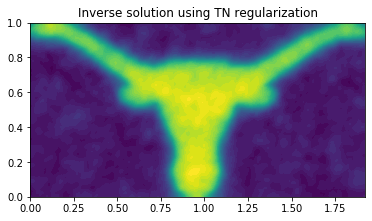

In [45]:
alpha = 0.001

uh = TrialFunction(V)
vh = TestFunction(V)

f = u_0
a = uh*vh*dx + alpha*inner(grad(uh), grad(vh))*dx
# How do we deal with matrix-vector product?
L = f*vh*dx

A, b = assemble_system(a, L)
uh = Function(V)
solve(A, uh.vector(), b)

vmin = np.min(uh.vector().get_local())
vmax = np.max(uh.vector().get_local())
plot(uh, title="Inverse solution using TN regularization", vmin=vmin, vmax = vmax)
plt.show()

### Prob3(b) TV regularization

 It          Energy           ||g||          (g,du)           alpha          tol_cg   cg_it
  0    6.638416e-01    5.154282e-04   -4.492217e-01    1.000000e+00    5.000000e-01       1
  1    6.634652e-01    1.151698e-04   -6.591702e-04    1.000000e+00    2.699729e-01       1
  2    6.634498e-01    3.086980e-05   -2.507434e-05    1.000000e+00    1.276161e-01       1
  3    6.634487e-01    1.175574e-05   -1.612035e-06    1.000000e+00    6.606980e-02       2
  4    6.634486e-01    4.943309e-06   -1.647825e-07    1.000000e+00    4.077192e-02       2
  5    6.634486e-01    2.163554e-06   -2.555485e-08    1.000000e+00    2.643900e-02       2
  6    6.634486e-01    9.772437e-07   -4.534854e-09    1.000000e+00    1.749122e-02       2
  7    6.634486e-01    4.521332e-07   -8.767296e-10    1.000000e+00    1.175540e-02       2
  8    6.634486e-01    2.129209e-07   -1.802694e-10    1.000000e+00    7.995936e-03       2
  9    6.634486e-01    1.015457e-07   -3.878949e-11    1.000000e+00    5.487130e

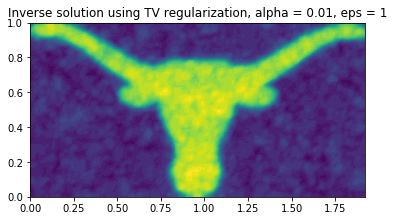

In [54]:
alpha = 0.01
eps = 1e3

u = Function(V)
u_hat = TestFunction(V)
u_tilde = TrialFunction(V)

E = Constant(0.5)*(u - u_0)*(u - u_0)*dx + alpha*sqrt( inner(grad(u), grad(u)) + eps )*dx
g = (u - u_0)*u_hat*dx + alpha/sqrt( inner(grad(u), grad(u)) + eps )*inner(grad(u), grad(u_hat))*dx

H = u_tilde*u_hat*dx + alpha/sqrt( inner(grad(u), grad(u)) + eps )*inner(grad(u_tilde), grad(u_hat))*dx \
    - alpha/(inner(grad(u), grad(u)) + eps)**(3)*inner(grad(u_tilde), grad(u)) \
    * inner(grad(u), grad(u_hat))*dx

solver = InexactNewtonCG()
solver.parameters["rel_tolerance"] = 1e-5
solver.parameters["abs_tolerance"] = 1e-9
solver.parameters["gdu_tolerance"] = 1e-18
solver.parameters["max_iter"] = 1000
solver.parameters["c_armijo"] = 1e-5
solver.parameters["print_level"] = 1
solver.parameters["max_backtracking_iter"] = 10


solver.solve(E, u, g, H)  
vmin = np.min(u.vector().get_local())
vmax = np.max(u.vector().get_local())
plot(u, title="Inverse solution using TV regularization, alpha = 0.01, eps = 1", vmin=vmin, vmax = vmax)
plt.show()

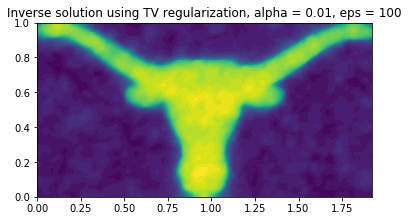

In [53]:
vmin = np.min(u.vector().get_local())
vmax = np.max(u.vector().get_local())
plot(u, title="Inverse solution using TV regularization, alpha = 0.01, eps = 100", vmin=vmin, vmax = vmax)
plt.show()